In [87]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# path = '/content/gdrive/MyDrive/Applied ML/'
path = './data/'
# save_path = 

In [88]:
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import files

# warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

seed = 3333
rnp = np.random.RandomState(seed)
# rnp.seed(3333)

# from copy import deepcopy
# import multiprocessing as mp
# from multiprocessing.pool import Pool, ThreadPool
# from functools import partial
# import time
# from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import os
import pickle
import gzip

# Class definition

In [89]:
class Mle:
  def __init__(self, data_path:str, sep:str=',', remove_head:bool=True,
              features_path:str=None, fsep:str=',', rem_fhead:bool=True,
              rebuild:bool=True, dataset_output_folder:str='') -> None:
              
    self.data_path     = data_path;       self.sep  = sep;    self.remove_head = remove_head
    self.features_path = features_path;   self.fsep = fsep;   self.rem_fhead   = rem_fhead
    self.rebuild = rebuild
    self.output_main_folder = 'outputs';   self.dataset_output_folder = dataset_output_folder

    self.users_id = {};                   self.items_id = {}

    self.users_rating       = [];         self.items_rating       = []
    self.users_rating_train = [];         self.items_rating_train = []
    self.users_rating_test  = [];         self.items_rating_test  = []

    self.user_ratings_count        = [];   self.item_ratings_count        = []
    self.user_ratings_count_train  = [];   self.item_ratings_count_train  = []
    self.user_ratings_count_test   = [];   self.item_ratings_count_test   = []

    self.user_ratings_cum        = [];     self.item_ratings_cum       = []
    self.user_ratings_cum_train  = [];     self.item_ratings_cum_train = []
    self.user_ratings_cum_test   = [];     self.item_ratings_cum_test  = []

    self.users_freq_rating =     [];      self.items_freq_rating     = []
    self.users_uniq_rating_nbr = [];      self.items_uniq_rating_nbr = []

    self.number_of_users = self.number_of_items = 0

    self.mle_train = [];  self.rmse_train = [];   self.rmse_test = []
    self.mle = None;      self.rmse = {};         self.params = {}


    self.data_loader()
    self.get_freq()
    # self.plots_path_builder()


# MAIN METHODS
  def get_data(self):
    nbr_user = len(self.users_id);      nbr_item = len(self.items_id)
    urat = [[] for _ in range(nbr_user)]
    irat = [[] for _ in range(nbr_item)]
    
    for u,v,r in self.data:
      urat[u].append((v,r))
      irat[v].append((u,r))
    
    for u in urat:
      self.users_rating.extend(u)
    for v in irat:
      self.items_rating.extend(v)
    
    self.number_of_users = nbr_user;    self.number_of_items = nbr_item
    self.user_ratings_cum = np.cumsum(self.user_ratings_count)
    self.item_ratings_cum = np.cumsum(self.item_ratings_count)

  def get_map(self, item):
    uid = self.users_id;              iid = self.items_id # address copy
    ucount = self.user_ratings_count; icount = self.item_ratings_count
    d = item.strip().split('::')
    # d[2] = float(d[2])
    if d[0] not in uid:
      uidx = len(uid)
      uid[d[0]] = uidx
      ucount.append(0)
    else:
      uidx = uid[d[0]]
    if d[1] not in iid:
      iidx = len(iid)
      iid[d[1]] = iidx
      icount.append(0)
    else:
      iidx = iid[d[1]]
    ucount[uidx] = ucount[uidx] + 1
    icount[iidx] = icount[iidx] + 1
    
    return (uidx, iidx, float(d[2]))

  def data_process(self) -> None:
    self.users_id = {};               self.items_id = {}
    self.users_rating = [];           self.items_rating = []
    self.user_ratings_count = [];     self.item_ratings_count = []
    with open(self.data_path, 'r') as file:
      raw_data = file.readlines()
      self.data = list(map(self.get_map, raw_data)) # user_id and item_id are updated here
    self.get_data()
    # print('Main data OK')

    if self.features_path:
      with open(self.features_path, 'r') as file:
        data = file.readlines()
        fid = {};     fitm = [];      ifea = []
        ficount = [];   ifcount = list(np.zeros((self.number_of_items,), dtype='int'))
        a = b = 0
        i = j = 0
        rm = False
        k = 0
        for d in tqdm(data, desc="Feature indexing"):
          if self.rem_fhead and not(rm):
            rm = not(rm)
            continue
          mf = d.strip().split(self.fsep)
          features = mf[2].strip().split('|')
          if mf[0] not in self.items_id:
            continue
          j = sum(ifcount[0:self.items_id[mf[0]]+1])
          ifcount[self.items_id[mf[0]]] = len(features)
          for f in features:
            if f not in fid:
              fid[f] = a
              ficount += [0]
              a += 1
            i = sum(ficount[0:fid[f]+1])
            ficount[fid[f]] += 1

            fitm.insert(i, (self.items_id[mf[0]]))
            ifea.insert(j, (fid[f]))
            j += 1

        self.features_id = fid;             self.number_of_features = len(ficount)
        self.feature_items = fitm;          self.item_features = ifea
        self.feature_items_count = np.array(ficount);    self.item_features_count = np.array(ifcount)
        self.feature_items_cum = np.cumsum(ficount);     self.item_features_cum = np.cumsum(ifcount)


  def split_data(self, ratio=0.1):
    np.random.seed(seed)
    nbr_user = self.number_of_users; nbr_item = self.number_of_items
    mrtr = []; irtr = {}; items_rating_train = []
    mrts = []; irts = {}; items_rating_test  = []

    for m in tqdm(range(nbr_user), desc="Data spliting"):
      urat = self.get_user_items_and_ratings(m, self.users_rating, self.user_ratings_cum)
      ui = len(urat)
      uj = int(np.round(ui*ratio))
      uk = np.random.choice(ui, uj, replace=False)
      for i, (n,r) in enumerate(urat):
        if i in uk:
          mrts += [(n, r)]
          if n not in irts:
            irts[n] = [(m, r)]
          else:
            irts[n] += [(m, r)]
        else:
          mrtr += [(n, r)]
          if n not in irtr:
            irtr[n] = [(m, r)]
          else:
            irtr[n] += [(m, r)]
      self.user_ratings_count_train.append(ui-uj);    self.user_ratings_count_test.append(uj)

    for n in range(nbr_item):
      if n in irtr:
        items_rating_train.extend(irtr[n]);    self.item_ratings_count_train.append(len(irtr[n]))
      else:
        self.item_ratings_count_train.append(0)

      if n in irts:
        items_rating_test.extend(irts[n]);    self.item_ratings_count_test.append(len(irts[n]))
      else:
        self.item_ratings_count_test.append(0)

    self.users_rating_train = mrtr;   self.items_rating_train = items_rating_train
    self.users_rating_test  = mrts;   self.items_rating_test = items_rating_test
    self.user_ratings_cum_train = np.cumsum(self.user_ratings_count_train)
    self.item_ratings_cum_train = np.cumsum(self.item_ratings_count_train)
    self.user_ratings_cum_test = np.cumsum(self.user_ratings_count_test)
    self.item_ratings_cum_test = np.cumsum(self.item_ratings_count_test)


  def get_freq(self) -> None:
    u, m = np.array(self.user_ratings_count), np.array(self.item_ratings_count)
    ufreq = []; mfreq = []
    uuniq = []; muniq = []
    while True:
      if len(u) == 0 & len(m) == 0:
        break
      if len(u) > 0:
        ufreq += [len(u[u==u[0]])]
        uuniq += [u[0]]
        u = u[u!=u[0]]
      if len(m) > 0:
        mfreq += [len(m[m==m[0]])]
        muniq += [m[0]]
        m = m[m!=m[0]]

    self.users_freq_rating = ufreq;  self.items_freq_rating = mfreq
    self.users_uniq_rating_nbr = uuniq;  self.items_uniq_rating_nbr = muniq


  def mle_loss(self, lambd:float=0.05, gamma:float=0.1, tau:float=0.011, dim:int=2, epochs=50,
               with_users_items:bool=False, with_features:bool=False) -> None:

    with_features = with_features and (self.features_path is not None)
    # Initialisation
    self.params = {'lambda': lambd, 'gamma': gamma, 'tau': tau, 'dim': dim, 'epoch': 0}
    self.epochs = epochs
    cost = float('inf')
  
    std = np.sqrt(5 / np.sqrt(dim));    fstd = 1 / np.sqrt(dim)

    self.user_matrix    = rnp.normal(0,  std, size=(self.number_of_users, dim));
    self.item_matrix    = rnp.normal(0,  std, size=(self.number_of_items, dim));
    # self.feature_matrix = rnp.normal(0, fstd, size=(self.number_of_features, dim))\
    #   if with_features else None;
    self.feature_matrix = np.zeros((self.number_of_features, dim))\
      if with_features else None;


    self.user_biases = np.zeros(self.number_of_users);
    self.item_biases = np.zeros(self.number_of_items)

    self.mle_train = np.zeros(epochs); self.rmse_train = np.zeros(epochs)
    self.rmse_test = np.zeros(epochs)

    # Loss calculation
    for epoch in tqdm(range(epochs), desc="Data Training"):
      # Biases update
      ## User
      self.update_user_biases()
      ## Item
      self.update_item_biases()

      # with ThreadPoolExecutor(max_workers=20) as pool:
      #   pool.submit(self.update_user_biases, list(range(nbr_user)))
      #   pool.submit(self.update_item_biases, list(range(nbr_item)))
      # usumb2 = np.dot(ubiases, ubiases)
      # msumb2 = np.dot(mbiases, mbiases)

      # Update
      if with_users_items:
      ## User
        self.update_users()
      ## Item
        self.update_items(with_features)
      ## Features
        if with_features:
          self.update_features()

      # Loss
      ## Train data
      self.update_train_errors(epoch, with_users_items, with_features)
      ## Test data
      self.update_test_errors(epoch)

      # Save the best model and parameters
      if cost > self.rmse_test[epoch]:
        cost = self.rmse_test[epoch]
        self.params['epoch']: epoch
        self.mle = self.mle_train[epoch]
        self.rmse = {'train': self.rmse_train[epoch], 'test': cost}
        self.model_manager()
      
      # Print epoch loss amd cost
      if epoch == 0 or (epoch+1) % 5 == 0:
        print(f"epoch: {epoch+1}\t loss: {self.mle:.2f}\t train_cost: {self.rmse['train']}\t test_cost: {self.rmse['test']}")
  
  def model(self,user_index, item_index):
    self.model_manager(load=True)
    return np.dot(self.user_matrix[user_index], self.item_matrix[item_index]) \
          + self.user_biases[item_index] + self.item_biases[item_index]


# PLOT METHODS
  def plot_freq(self, save=False, fgsize=[6,6], ftsize=11, alpha=0.7,
                title = 'Power low', xlabel = 'count', ylabel = 'frequency',
                ulabel = 'user', mlabel = 'item',
                ucolor = '#0E88FF', mcolor = '#FF0000'):
    # Initialisation
    ux = self.users_uniq_rating_nbr
    mx = self.items_uniq_rating_nbr
    uy = self.users_freq_rating
    my = self.items_freq_rating

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xscale("log", base=10)
    ax.set_yscale("log", base=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(ux, uy, alpha=alpha, color=ucolor, label=ulabel, marker='.')
    ax.scatter(mx, my, alpha=alpha, color=mcolor, label=mlabel, marker='.')

    # Legend
    # ax.legend(fontsize=ftsize)
    ax.set_title(title, pad=10)
    self.save_plot(plt, f'{self.plot_path}/power-low', save=save)
    
  def rating_distribution(self, save=False, fgsize=[6,6], ftsize=11, alpha=1,
                title = 'Ratings distribution', xlabel = 'ratings', ylabel = 'frequency',
                color = '#0E88FF'):
    # Frequency calculation
    rdist = [[],[]]
    rate = []
    for _,_,r in self.data:
      if r in rdist[0]:
        i = rdist[0].index(r)
        rdist[1][i] = rdist[1][i] + 1
      else:
        rdist[0].append(r)
        rdist[1].append(1)
      rate.append(r)
      
    # Initialisation
    n = sum(rdist[1])
    x = np.array(rdist[0])
    y = np.array(rdist[1]) / n

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    # ax.bar(x, y, color = color, rwidth=0.9) #
    ax.hist(rate, rwidth=0.9)

    # Legend
    # ax.legend(fontsize=ftsize)
    ax.set_title(title, pad=10)
    self.save_plot(plt, f'{self.plot_path}/ratings-distribution', save=save)


  def plot_loss(self, error='mle', save=False, fgname='mle', fgsize=[6,6], ftsize=11, alpha=1,
                title = 'Lost function', xlabel = 'Iteration', ylabel = 'mle value',
                lcolor = '#0E88FF', ecolor = '#FF0000') -> None:
    # Initialisation
    if self.mle_train is None:
      self.mle_loss()
    y_train = self.mle_train if error == 'mle' else self.rmse_train
    y_test  = []  if error == 'mle' else self.rmse_test
    x = np.array(range(1,self.epochs+1))

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.plot(x, y_train, alpha=alpha, color=lcolor, marker="+", label='Training set')
    if error == 'rmse':
      ax.plot(x, y_test, alpha=alpha, color=ecolor, marker="*", label='Testing set')
    ax.grid(alpha=0.5)
    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.params['dim']}", pad=10)
    self.save_plot(plt, f"{self.plot_path}/{fgname}-dim{self.params['dim']}-epochs{self.epochs}", save=save)

  def item_embedding(self, feature_id, save=False, fgname='item-embedding', fgsize=[8,8], ftsize=11, alpha=1,
                title = 'Items embedding', xlabel = 'first component', ylabel = 'second component',
                color = '#0E88FF') -> None:
    # Initialisation
    items = self.get_feature_items(feature_id, self.feature_items, self.feature_items_cum)
    x = self.item_matrix[items,0];    y = self.item_matrix[items,1]
    f = self.feature_matrix[feature_id];

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(x, y, alpha=alpha, color=color, marker='.')
    ax.scatter(f[0], f[1])

    # Legend
    # ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.params['dim']}", pad=10)
    self.save_plot(plt, f"{self.plot_path}/{fgname}-dim{self.params['dim']}-epochs{self.epochs}", save=save)

  def feature_embedding(self, save=False, fgname='feature-embedding', fgsize=[8,8], ftsize=11, alpha=1,
                title = 'Features embedding', xlabel = 'first component', ylabel = 'second component',
                color = '#0E88FF') -> None:
    # Initialisation
    x = self.feature_matrix[:,0];    y = self.feature_matrix[:,1]

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(x, y, alpha=alpha, color=color)
    for fid in self.features_id:
      ax.annotate(fid, (x[self.features_id[fid]], y[self.features_id[fid]]))
    # Legend
    # ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.params['dim']}", pad=10)
    self.save_plot(plt, f"{self.plot_path}/{fgname}-dim{self.params['dim']}-epochs{self.epochs}" , save=save)


# USEFUL METHODS
## SETTERS
  def update_user_biases(self):
    for m in range(self.number_of_users):
      b = 0
      ratings = self.get_user_items_and_ratings(m, self.users_rating_train, self.user_ratings_cum_train)
      for n, r in ratings:
        b = b + self.params['lambda'] * (r - (np.dot(self.user_matrix[m], self.item_matrix[n]) + self.item_biases[n]))
      b = b / (self.params['lambda'] * len(ratings) + self.params['gamma'])
      self.user_biases[m] = b

  def update_item_biases(self):
    for n in range(self.number_of_items):
      b = 0
      ratings = self.get_item_users_and_ratings(n, self.items_rating_train, self.item_ratings_cum_train)
      for m, r in ratings:
        b += self.params['lambda'] * (r - (np.dot(self.user_matrix[m], self.item_matrix[n]) + self.user_biases[m]))
      b = b / (self.params['lambda'] * len(ratings) + self.params['gamma'])
      self.item_biases[n] = b

  def update_users(self):
    for m in range(self.number_of_users):
      ratings = self.get_user_items_and_ratings(m, self.users_rating_train, self.user_ratings_cum_train)
      A = np.zeros((self.params['dim'],self.params['dim']));   x = np.zeros(self.params['dim'])
      for n, r in ratings:
        A += self.params['lambda'] * np.outer(self.item_matrix[n],self.item_matrix[n])
        x += self.params['lambda'] * self.item_matrix[n] * (r - (self.user_biases[m] + self.item_biases[n]))
      A += self.params['tau'] * np.eye(self.params['dim'])
      L = np.linalg.cholesky(A)
      self.user_matrix[m] = np.linalg.inv(L.T) @ np.linalg.inv(L) @ x
  
  def update_items(self, with_features):
    for n in range(self.number_of_items):
      ratings = self.get_item_users_and_ratings(n, self.items_rating_train, self.item_ratings_cum_train)
      fn = self.get_item_features(n, self.item_features, self.item_features_cum) # Get item features
      A = np.zeros((self.params['dim'],self.params['dim']));   c = np.zeros(self.params['dim'])
      for m, r in ratings:
        A += self.params['lambda'] * np.outer(self.user_matrix[m], self.user_matrix[m])
        c += self.params['lambda'] * self.user_matrix[m] * (r - (self.user_biases[m] + self.item_biases[n]))
      A += self.params['tau'] * np.eye(self.params['dim'])
      c += (self.params['tau'] / np.sqrt(self.item_features_count[n])) * sum(self.feature_matrix[fn,:]) if with_features else 0
      L = np.linalg.cholesky(A)
      self.item_matrix[n] = np.linalg.inv(L.T) @ np.linalg.inv(L) @ c

  def update_features(self):
    for k in range(self.number_of_features):
      items = self.get_feature_items(k, self.feature_items, self.feature_items_cum)
      sum_fn = 0; sum_vn = 0
      for n in items:
        fn = self.get_item_features(n, self.item_features, self.item_features_cum)
        sum_fn += 1 / self.item_features_count[n]
        sum_vn += (self.item_matrix[n] * np.sqrt(self.item_features_count[n]) \
          - (sum(self.feature_matrix[fn,:]) - self.feature_matrix[k])) \
            / self.item_features_count[n]
      self.feature_matrix[k] = sum_vn / (1 + sum_fn)

  def update_train_errors(self, epoch, with_users_items, with_features):
    mle1 = 0
    fn = lambda n: self.get_item_features(n, self.item_features, self.item_features_cum)
    if with_users_items:
      if with_features:
        # self.update_features()
        fsumpred2 = np.sum([f @ f.T for f in self.feature_matrix])  # Feature squred
        sum_fn = lambda n: sum(self.feature_matrix[fn(n),:]) / np.sqrt(self.item_features_count[n])
        msumpred2 = np.sum([(v - sum_fn(n)) @ (v - sum_fn(n)).T for n,v in enumerate(self.item_matrix)])
      else:
        msumpred2 = np.sum([v @ v.T for v in self.item_matrix])  #  # Item squared without features
      usumpred2 = np.sum([u @ u.T for u in self.user_matrix])    #  # User squared
    usumb2 = np.dot(self.user_biases, self.user_biases)
    msumb2 = np.dot(self.item_biases, self.item_biases)

    for m in range(self.number_of_users):
      ratings = self.get_user_items_and_ratings(m, self.users_rating_train, self.user_ratings_cum_train)
      for n, r in ratings:
        mle1 = mle1 + (r - (np.dot(self.user_matrix[m], self.item_matrix[n]) \
          + self.user_biases[m] + self.item_biases[n]))**2
    mle_train = self.params['lambda']*mle1 + self.params['gamma']*(usumb2+msumb2)
    mle_train += self.params['tau']*(usumpred2+msumpred2) if with_users_items else 0
    mle_train += self.params['tau']*fsumpred2 if with_features else 0
    self.mle_train[epoch] = mle_train / 2
    self.rmse_train[epoch] = np.sqrt(mle1 / self.user_ratings_cum_train[-1])

  def update_test_errors(self, epoch):
    mle1 = 0
    for m in range(self.number_of_users):
      ratings = self.get_user_items_and_ratings(m, self.users_rating_test, self.user_ratings_cum_test)
      for n, r in ratings:
        mle1 = mle1 + (r - (np.dot(self.user_matrix[m], self.item_matrix[n]) \
          + self.user_biases[m] + self.item_biases[n]))**2
    self.rmse_test[epoch] = np.sqrt(mle1 / self.user_ratings_cum_test[-1])


## GETTERS
  def get_user_items_and_ratings(self, user_index, data=None, cum=None):
    if data is None:
      data = self.users_rating
      cum = self.user_ratings_cum
    a = 0 if user_index == 0 else cum[user_index-1]
    b = cum[user_index]
    return data[a:b]

  def get_item_users_and_ratings(self, item_index, data=None, cum=None):
    if data is None:
      data = self.items_rating
      cum  = self.item_ratings_cum
    a = 0 if item_index == 0 else cum[item_index-1]
    b = cum[item_index]
    return data[a:b]

  def get_item_features(self, item_index, data=None, cum=None):
    if data is None:
      data = self.item_features
      cum  = self.item_features_cum
    a = 0 if item_index == 0 else cum[item_index-1]
    b = cum[item_index]
    return data[a:b]

  def get_feature_items(self, feature_index, data=None, cum=None):
    if data is None:
      data = self.feature_items
      cum = self.feature_items_cum
    a = 0 if feature_index == 0 else cum[feature_index-1]
    b = cum[feature_index]
    return data[a:b]


# OTHERS
  def save_plot(self, fig_plt, name, ext='.pdf', save=True):
    if save:
      filenane = f"{name}{ext}"
      fig_plt.savefig(filenane)
    else:
      fig_plt.show()

  def plots_path_builder(self):
    n = self.user_ratings_cum[-1]
    d = 1;          p = ''
    if n >= 10**3 and n < 10**6:
      d = 10**3;    p = 'k'
    else:
      d = 10**6;    p = 'm'
    subpath = f"ml-{np.floor(n/d):.0f}{p}"
    path = f'./{self.output_main_folder}/{subpath}'

    try:
      if os.path.exists(path):
        print("Output directory '%s' loaded successfully" % path)
      else:
        os.makedirs(path, exist_ok = True)
        print("Output directory '%s' created successfully" % path)
      if not self.dataset_output_folder:
        self.dataset_output_folder = subpath
      # Update paths
      self.plot_path = path
    except OSError as error:
      print("Directory '%s' can not be created" % path)

  def load_output_path(self, mute=False): # To set output path
    filename = "output_path.pkl"
    path = ''
    try:
      if self.rebuild:
        pass
      else:
        with open(filename, 'rb') as file:
          path = pickle.load(file)
    except (OSError, IOError) as error:
      pass
    
    if self.dataset_output_folder:
      path = f'./{self.output_main_folder}/{self.dataset_output_folder}' # dataset_output_folder has to be set
    if path:
      if os.path.exists(path):
        with open(filename, 'wb') as file:
          pickle.dump(path, file)
      else:
        raise Exception(f"Output path {path} doesn't exist: Enter a valid one or set the class instance with option 'rebuild=True'")
    else:
      raise Exception("Output path is empty: Run the class with option 'rebuild=True'")
    # Update paths
    self.output_path = path
    self.plot_path = path

    if not mute:
      print(f"Model currently running on file {path.split('-')[-1]} dataset")
    
  def data_loader(self):
    # filename = 'data.pkl'
    # if not self.rebuild:
    #   self.load_output_path()
    # err = False
    # try:
    #   if self.rebuild:
    #     pass
    #   else:
    #     filepath = f"{self.output_path}/{filename}"
    #     with open(filepath, 'rb') as file:
    #       print(filepath)
    #       data = pickle.load(file)
    #       # print(data)
    #       self.users_id           = data['uid'];            self.items_id           = data['iid']
    #       self.users_rating       = data['urat'];           self.items_rating       = data['irat']
    #       self.user_ratings_count = data['ucount'];         self.item_ratings_count = data['icount']

    #       self.features_id          = data['fid']
    #       self.feature_items        = data['fitm'];         self.item_features       = data['ifea']
    #       self.feature_items_count  = data['ficount'];      self.item_features_count = data['ifcount']
          
    #       self.users_rating_train       = data['uratr'];    self.items_rating_train       = data['iratr']
    #       self.users_rating_test        = data['urats'];    self.items_rating_test        = data['irats']
    #       self.user_ratings_count_train = data['ucountr'];  self.item_ratings_count_train = data['icountr']
    #       self.user_ratings_count_test  = data['ucounts'];  self.item_ratings_count_test  = data['icounts']


    #       self.number_of_users    = len(self.user_ratings_count)
    #       self.number_of_items    = len(self.item_ratings_count)
    #       self.number_of_features = len(self.feature_items_count)

    #       self.user_ratings_cum   = np.cumsum(self.user_ratings_count)
    #       self.item_ratings_cum   = np.cumsum(self.item_ratings_count)
    #       self.feature_items_cum  = np.cumsum(self.feature_items_count)
    #       self.item_features_cum  = np.cumsum(self.item_features_count)

    #       self.user_ratings_cum_train = np.cumsum(self.user_ratings_count_train)
    #       self.item_ratings_cum_train = np.cumsum(self.item_ratings_count_train)
    #       self.user_ratings_cum_test  = np.cumsum(self.user_ratings_count_test)
    #       self.item_ratings_cum_test  = np.cumsum(self.item_ratings_count_test)

    # except (OSError, IOError) as e:
    #   print('Data loading error\n', e)
    #   err = True
      
    # if self.rebuild or err:
    # self.get_data()
    self.data_process()
    self.split_data()

    self.plots_path_builder()
    self.load_output_path()
      # filename = f"{self.output_path}/{filename}"

      # data = {
      #   'uid':      self.users_id,                  'iid':      self.items_id,
      #   'urat':     self.users_rating,              'irat':     self.items_rating,
      #   'ucount':   self.user_ratings_count,        'icount':   self.item_ratings_count,

      #   'fid':      self.features_id,
      #   'fitm':     self.feature_items,             'ifea':     self.item_features,
      #   'ficount':  self.feature_items_count,       'ifcount':  self.item_features_count,

      #   'uratr':    self.users_rating_train,        'iratr':    self.items_rating_train,
      #   'urats':    self.users_rating_test,         'irats':    self.items_rating_test,
      #   'ucountr':  self.user_ratings_count_train,  'icountr':  self.item_ratings_count_train,
      #   'ucounts':  self.user_ratings_count_test,   'icounts':  self.item_ratings_count_test
      # }
      # # print(data['uid'])
      
      # with open(filename, 'wb') as file:
      #   pickle.dump(data, file)
        
      # self.rebuild = False

  def model_manager(self, load=False):
    self.load_output_path(True)
    filename = "model.pkl"
    filepath = f"{self.output_path}/{filename}"
    try:
      if load:
        with open(filepath, 'rb') as file:
          data = pickle.load(file)
          self.user_matrix = data['upred'];       self.item_matrix = data['ipred']
          self.feature_matrix = data['fpred']
          self.user_biases = data['ubiases'];     self.item_biases = data['ibiases']
          self.mle = data['mle'];                 self.rmse = data['rmse']
          self.params = data['params']
      else:
        data = {
          'upred':    self.user_matrix,           'ipred':    self.item_matrix,
          'fpred':    self.feature_matrix,
          'ubiases':  self.user_biases,           'ibiases':  self.item_biases,
          'mle':      self.mle,                   'rmse':     self.rmse,
          'params':   self.params
        }
      
        with open(filepath, 'wb') as file:
          pickle.dump(data, file)

    except (OSError, IOError) as e:
      print('Model loading error\n', e)
      

Test

In [90]:
test = Mle(path + 'ratings.dat', features_path=path + 'movies.dat', sep='::', fsep='::',
  remove_head=False, rem_fhead=False, dataset_output_folder='')

# test = Mle(path + 'ratings.csv', features_path=path + 'movies.csv', sep=',', fsep=',',
#   remove_head=True, rem_fhead=True, dataset_output_folder='', rebuild=True)

Data spliting: 100%|██████████| 69878/69878 [00:16<00:00, 4133.35it/s]


Output directory './outputs/ml-10m' loaded successfully
Model currently running on file 10m dataset


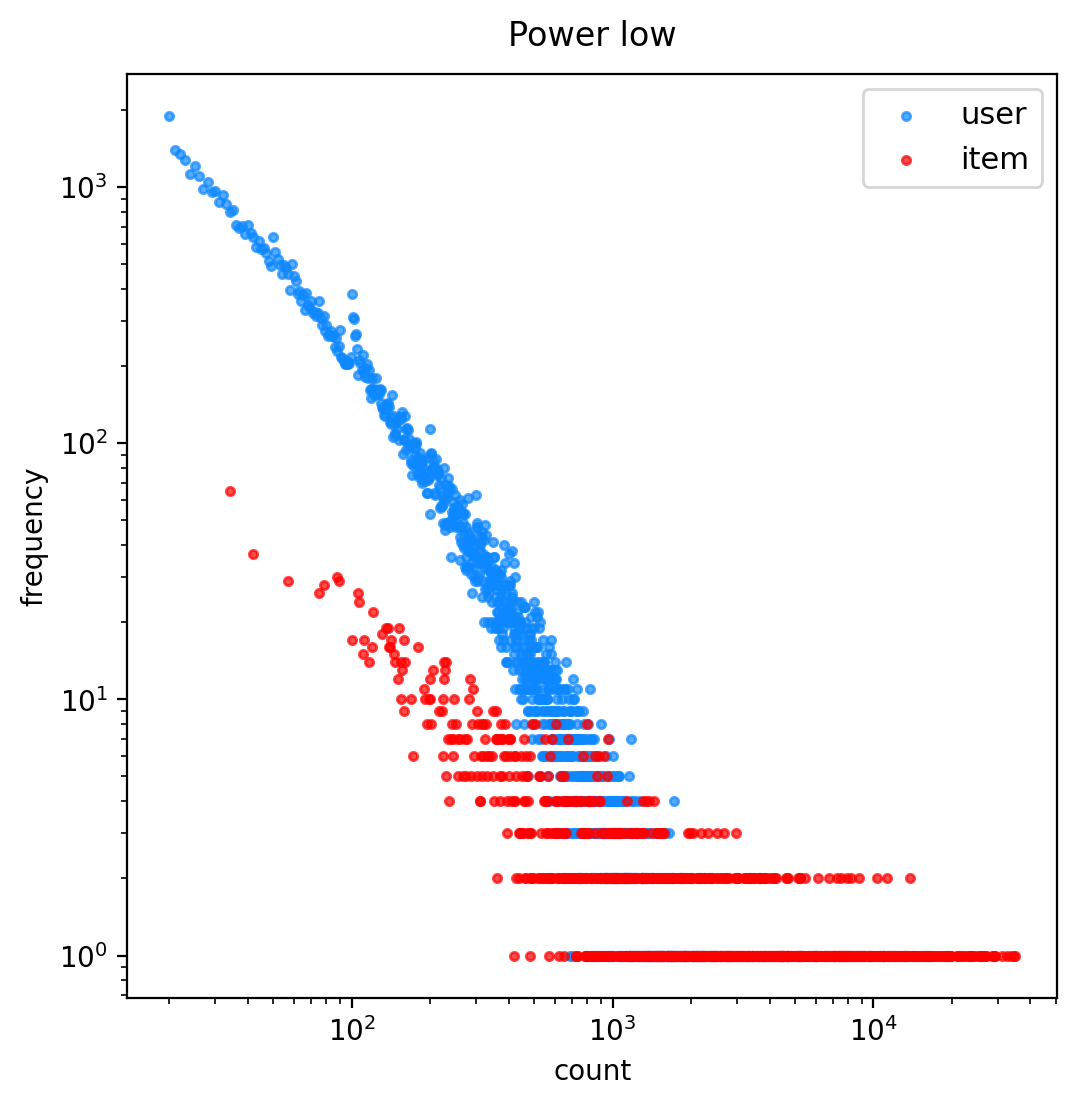

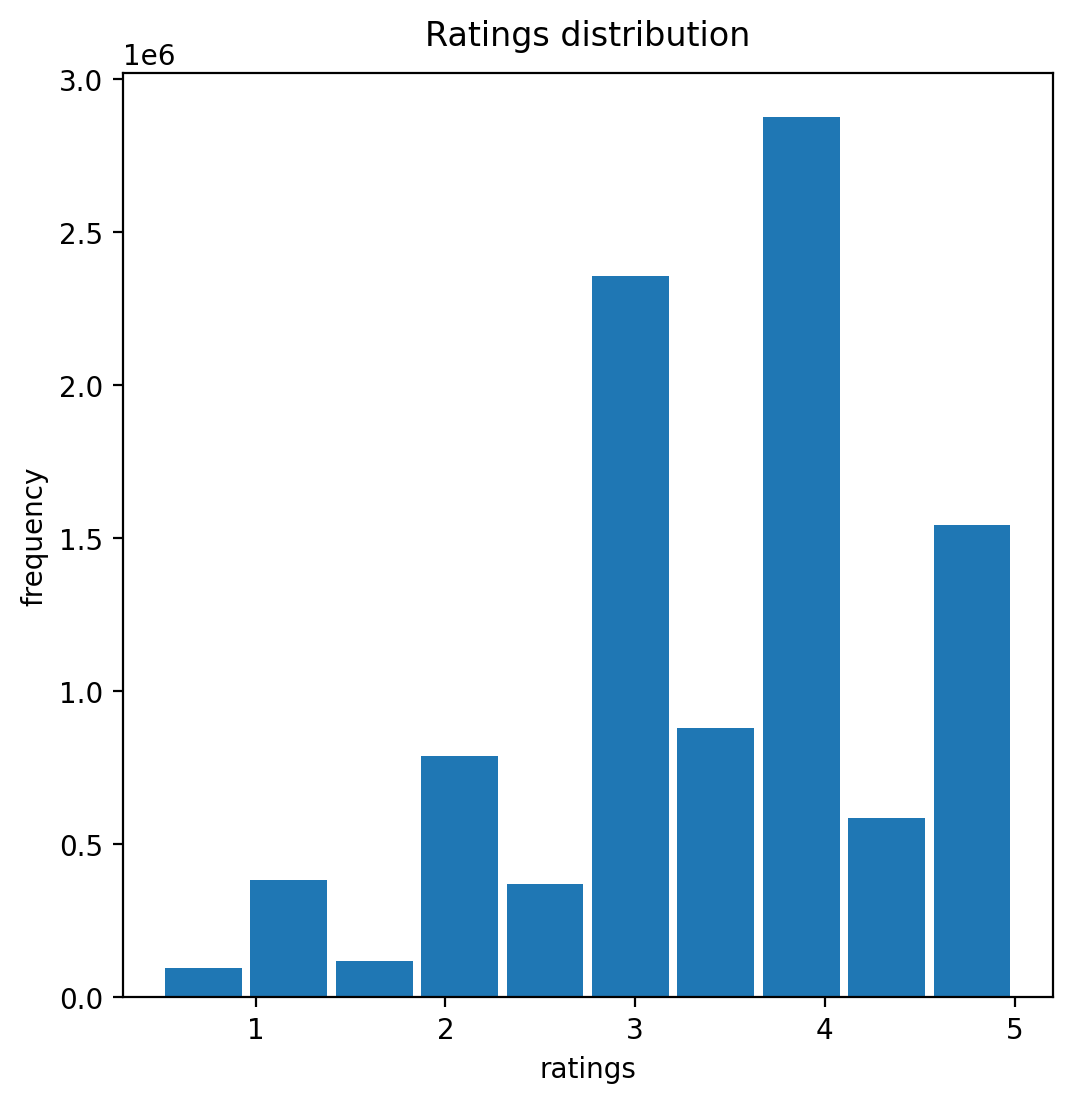

In [91]:
test.plot_freq(save=True)
test.rating_distribution(save=True)

# Model training
## Biases only model

In [92]:
test.mle_loss(epochs=10, dim=2, with_users_items=False, with_features=False)

Data Training:  10%|█         | 1/10 [00:25<03:51, 25.70s/it]

epoch: 1	 loss: 5753099.88	 train_cost: 5.036705148215345	 test_cost: 5.084043452607674


Data Training:  50%|█████     | 5/10 [02:07<02:07, 25.57s/it]

epoch: 5	 loss: 5741469.34	 train_cost: 5.0340130061580455	 test_cost: 5.081301594328379


Data Training: 100%|██████████| 10/10 [04:15<00:00, 25.53s/it]

epoch: 10	 loss: 5736289.47	 train_cost: 5.033949428534353	 test_cost: 5.081235477292744


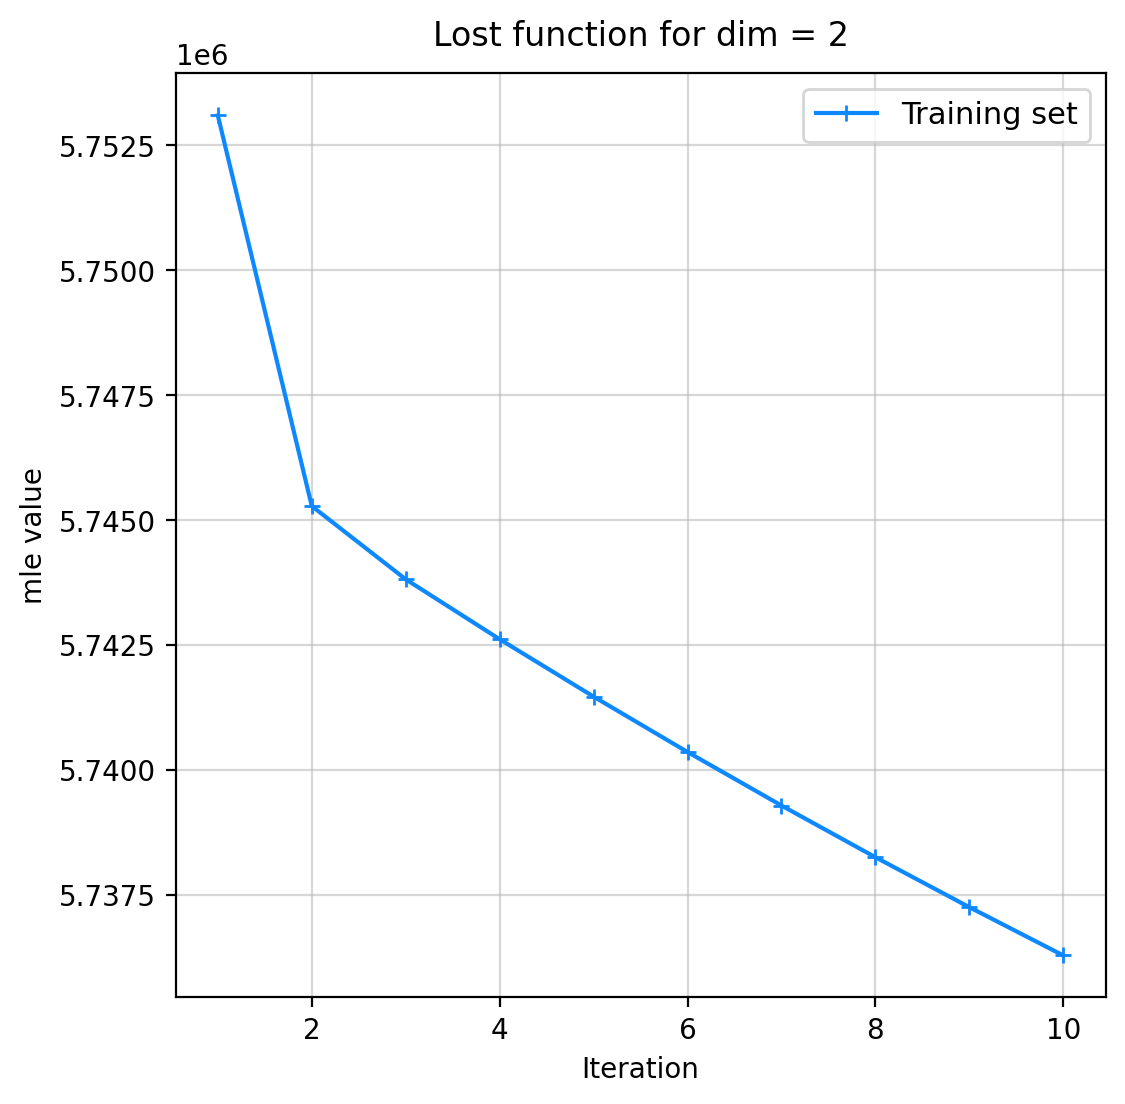

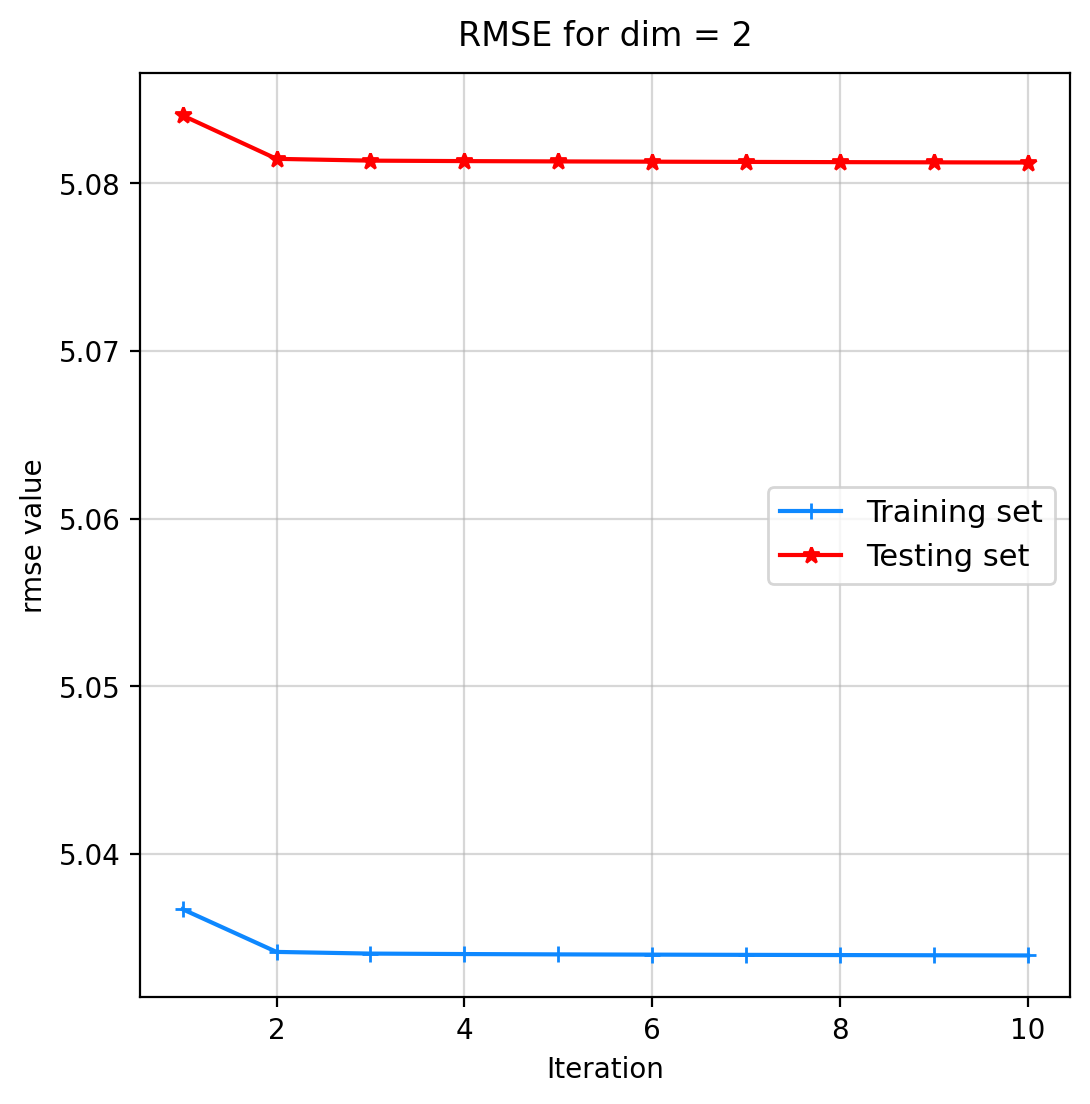

In [93]:
test.plot_loss(save=True, fgname='loss-biases-only')
test.plot_loss(error='rmse', fgname='rmse-biases-only', title='RMSE', ylabel='rmse value', save=True)

In [94]:
m = 4
# test.get_user_items_and_ratings(0, test.users_rating_train, test.user_ratings_cum_train)
im = test.get_user_items_and_ratings(m, test.users_rating_test, test.user_ratings_cum_test)
# test.user_ratings_cum_train
[(r, f"{test.model(m,n):.1f}") for n,r in im]

[(4.0, '8.8'),
 (4.0, '4.6'),
 (5.0, '13.9'),
 (4.0, '-6.6'),
 (5.0, '-2.7'),
 (4.0, '16.2'),
 (4.0, '-0.1'),
 (4.0, '-5.0'),
 (5.0, '-4.8')]

## Model with users and items vectors

In [102]:
test.mle_loss(epochs=10, dim=2, with_users_items=True, with_features=False)

Data Training:  10%|█         | 1/10 [01:34<14:09, 94.39s/it]

epoch: 1	 loss: 247804.16	 train_cost: 0.9495659882615227	 test_cost: 0.9817956465276738


Data Training:  50%|█████     | 5/10 [07:49<07:49, 93.90s/it]

epoch: 5	 loss: 187614.28	 train_cost: 0.8214400224565469	 test_cost: 0.8463968942456004


Data Training: 100%|██████████| 10/10 [15:39<00:00, 93.91s/it]

epoch: 10	 loss: 177485.47	 train_cost: 0.8101031645339825	 test_cost: 0.8343356809170166


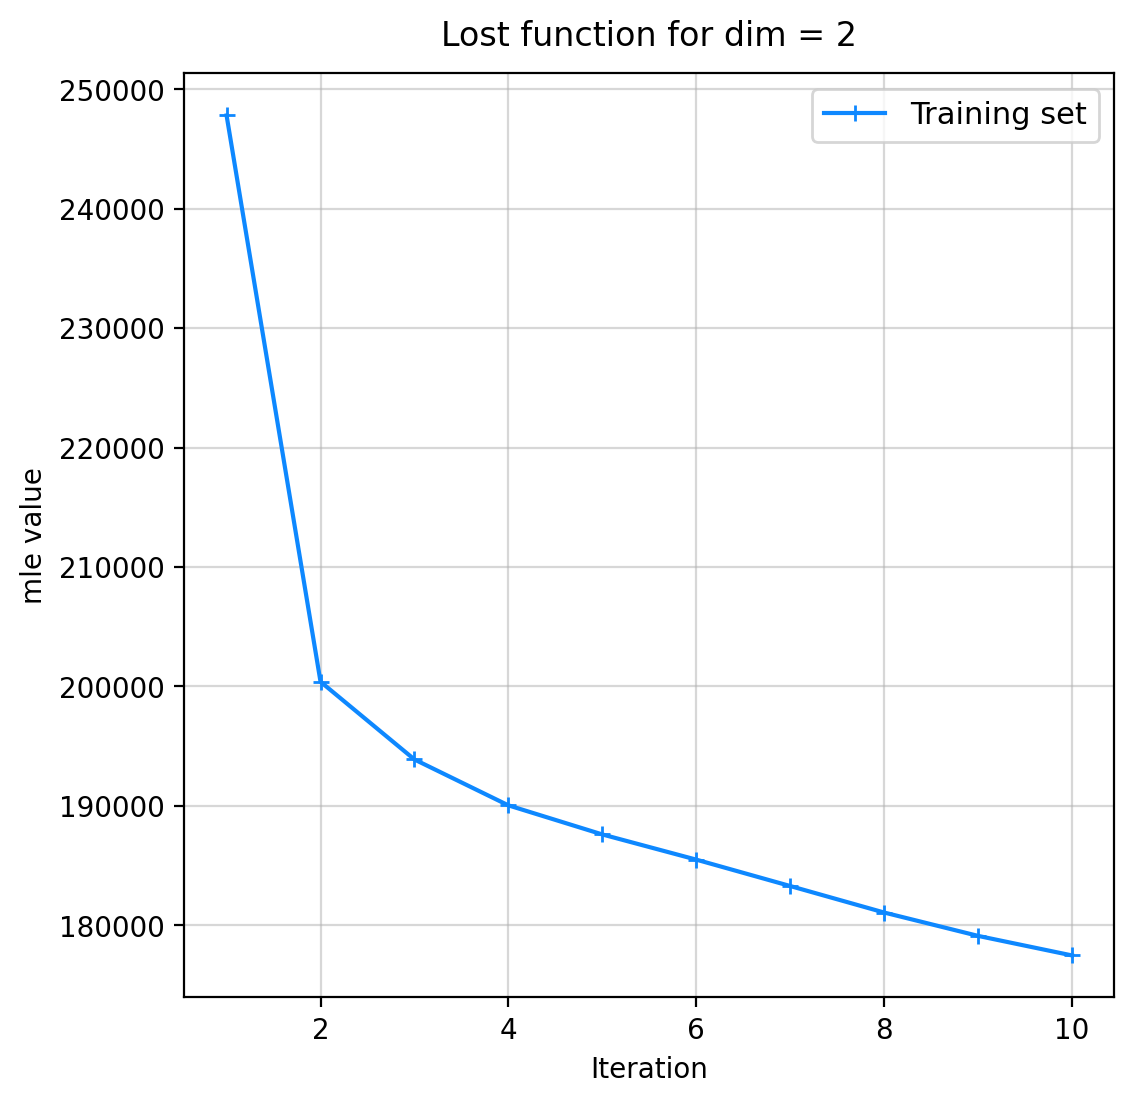

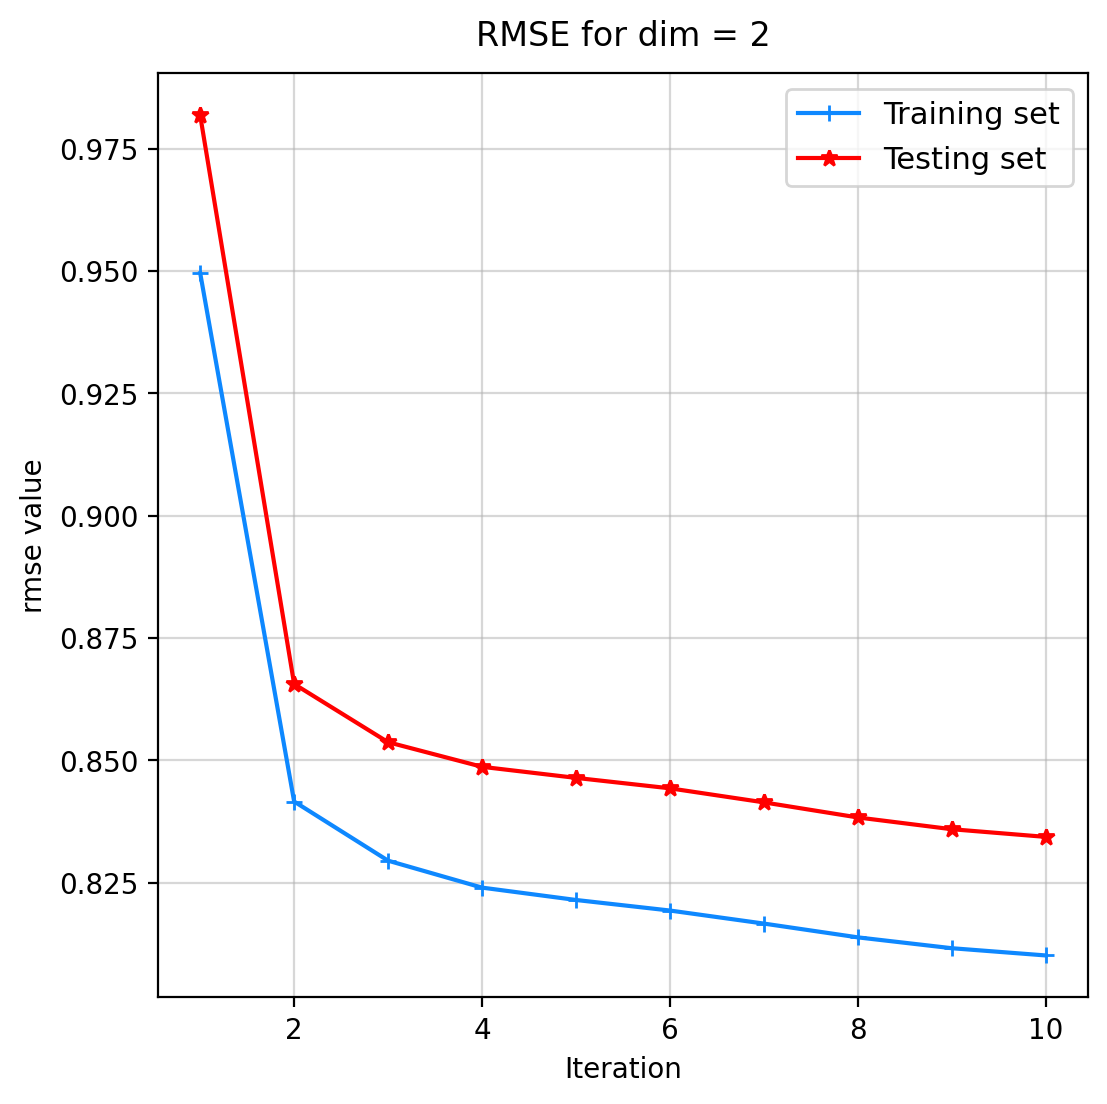

In [103]:
test.plot_loss(save=True, fgname='loss-users-items')
test.plot_loss(save=True, error='rmse', fgname='rmse-users-items', title='RMSE', ylabel='rmse value')
# test.item_embedding()
# test.feature_embedding()

In [104]:
m = 4
# test.get_user_items_and_ratings(0, test.users_rating_train, test.user_ratings_cum_train)
im = test.get_user_items_and_ratings(m, test.users_rating_test, test.user_ratings_cum_test)
# test.user_ratings_cum_train
[(r, f"{test.model(m,n):.1f}") for n,r in im]

[(4.0, '3.7'),
 (4.0, '5.2'),
 (5.0, '4.1'),
 (4.0, '3.5'),
 (5.0, '3.5'),
 (4.0, '5.4'),
 (4.0, '4.2'),
 (4.0, '4.4'),
 (5.0, '5.6')]

## Model with users, items vectors and features

In [105]:
test.mle_loss(epochs=10, dim=2, with_users_items=True, with_features=True)

Data Training:  10%|█         | 1/10 [01:34<14:14, 94.89s/it]

epoch: 1	 loss: 247979.85	 train_cost: 0.9487446452086827	 test_cost: 0.977831459523308


Data Training:  50%|█████     | 5/10 [07:49<07:48, 93.75s/it]

epoch: 5	 loss: 182616.28	 train_cost: 0.8138415781839531	 test_cost: 0.8350664262024536


Data Training: 100%|██████████| 10/10 [15:42<00:00, 94.21s/it]

epoch: 10	 loss: 173500.68	 train_cost: 0.8080314521734797	 test_cost: 0.8300411702924231


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


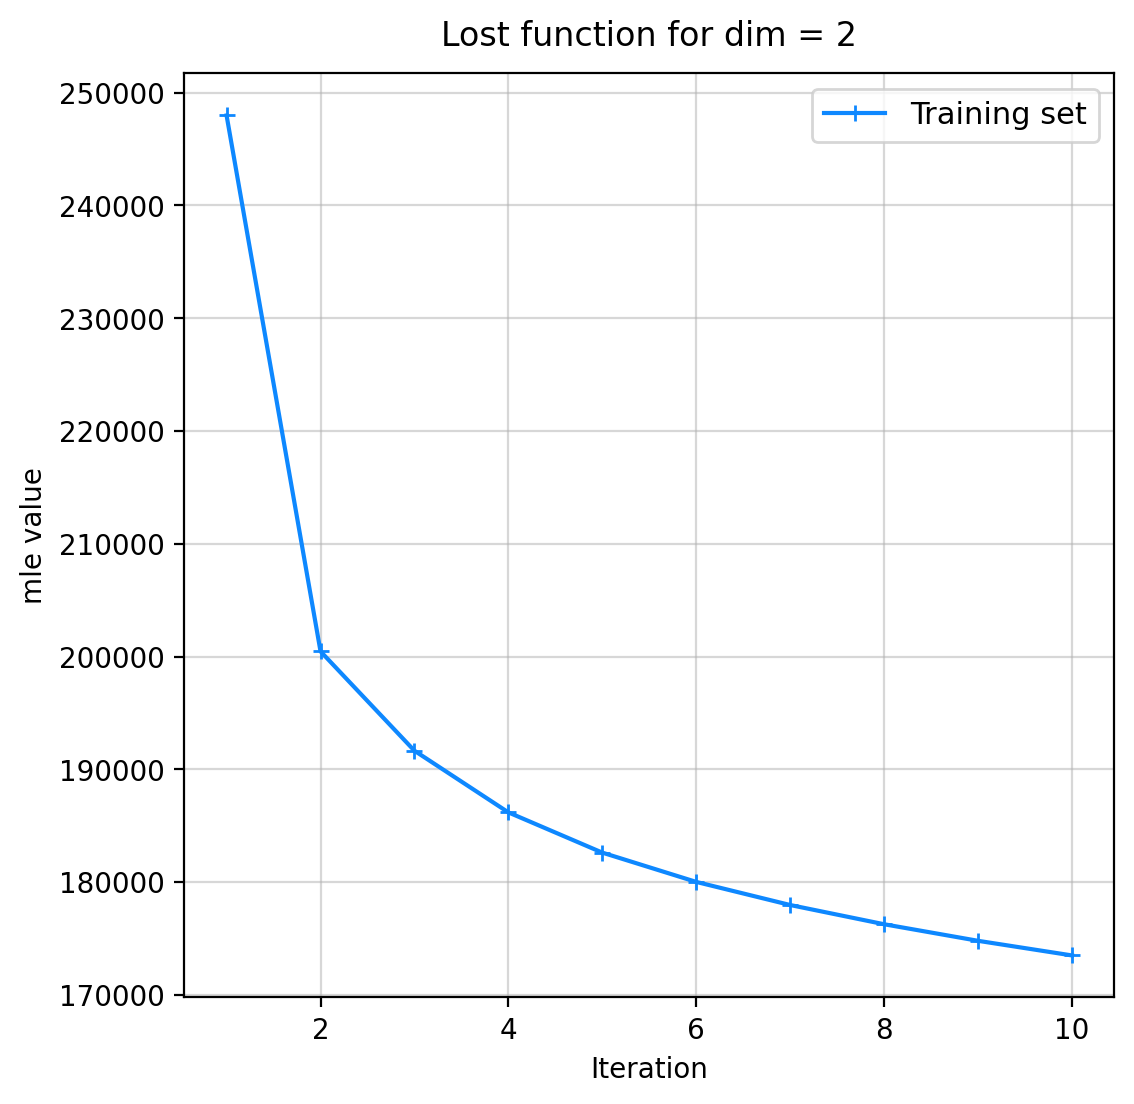

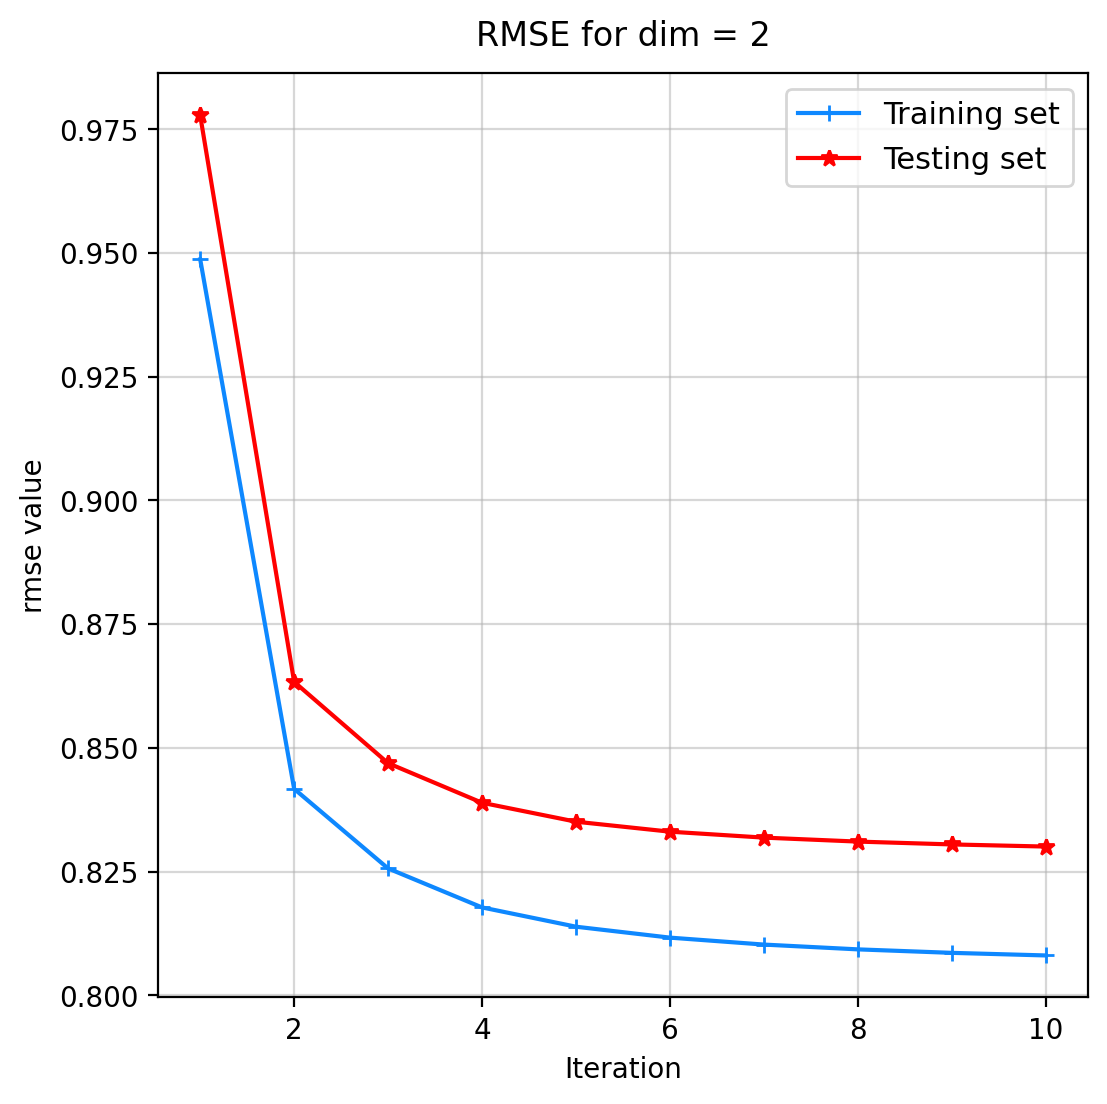

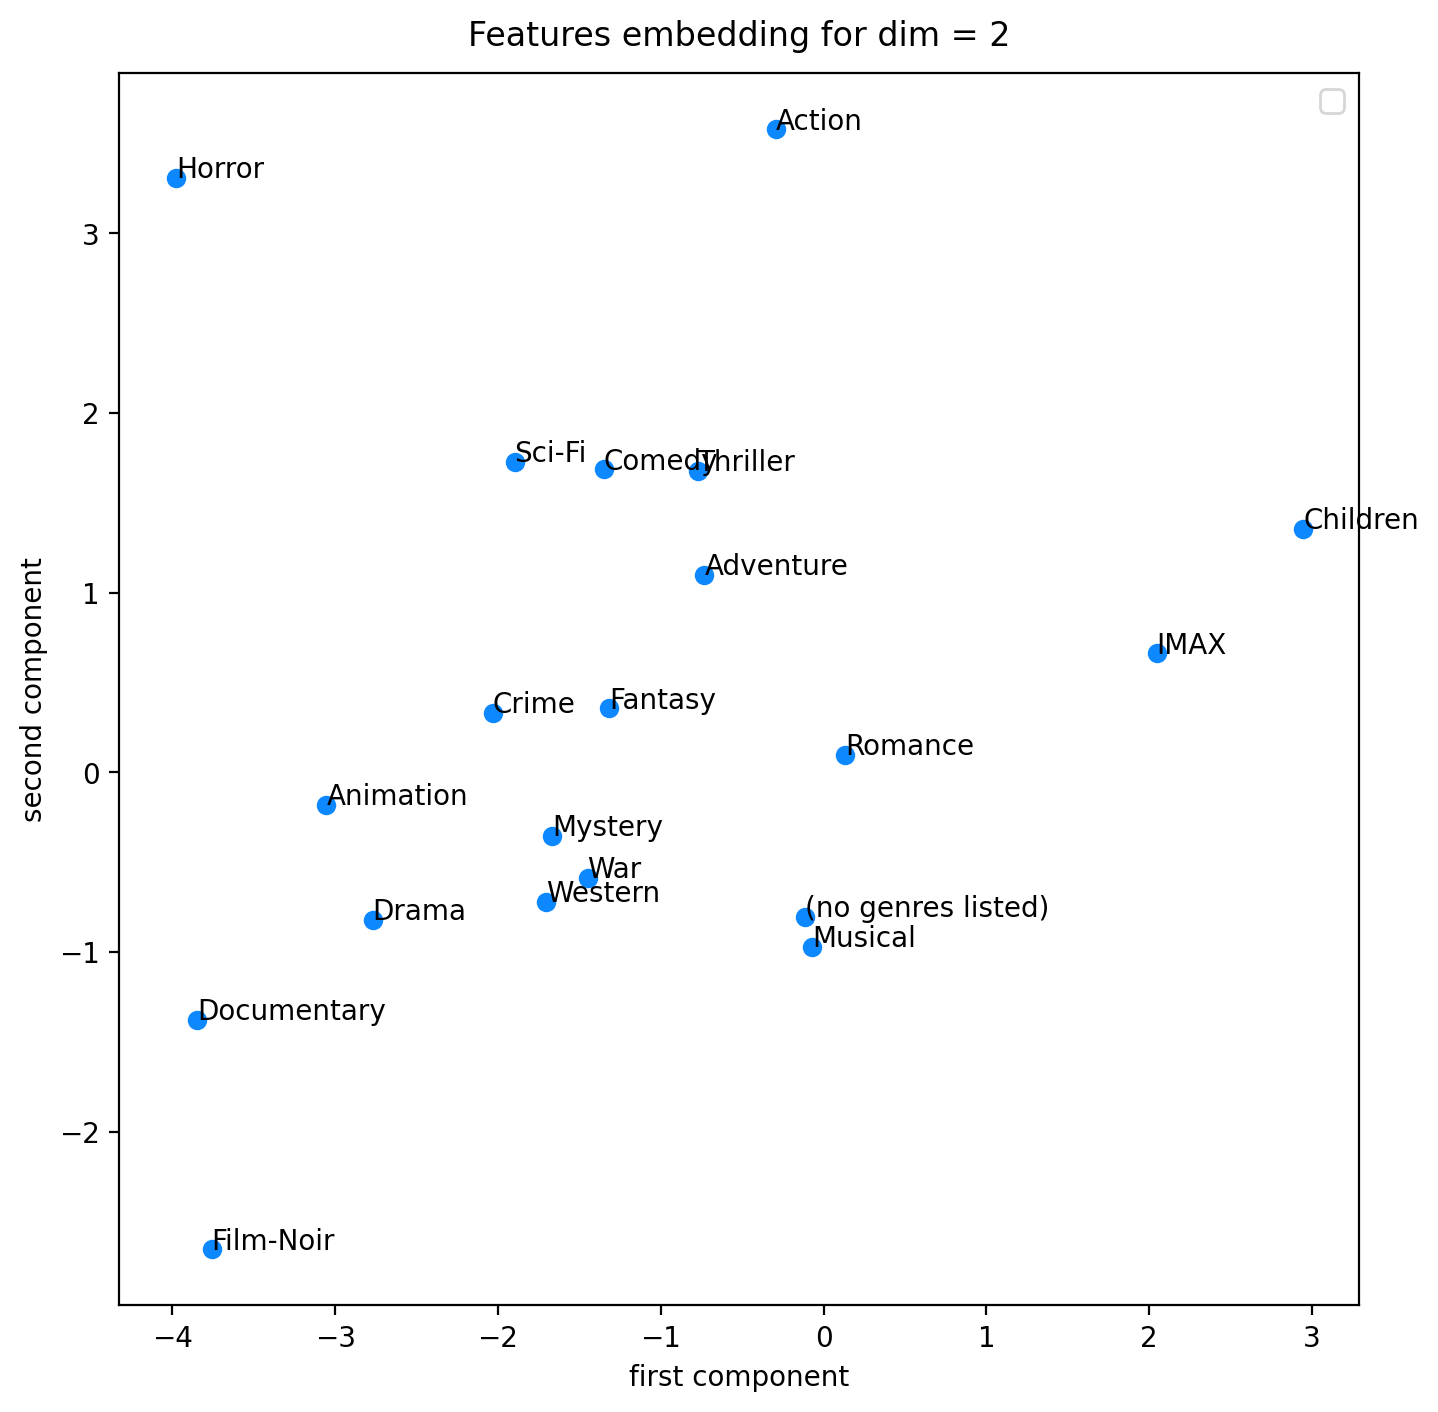

In [107]:
test.plot_loss(save=True, fgname='loss-users-items-features')
test.plot_loss(save=True, error='rmse', fgname='rmse-users-items-features', title='RMSE', ylabel='rmse value')
# test.item_embedding(3)
test.feature_embedding(save=True)

### Prediction

In [ ]:
m = 2
# test.get_user_items_and_ratings(0, test.users_rating_train, test.user_ratings_cum_train)
im = test.get_user_items_and_ratings(m, test.users_rating_test, test.user_ratings_cum_test)
# test.user_ratings_cum_train
[(r, f"{test.model(m,n):.1f}") for n,r in im]

[(4.5, '3.2'), (4.0, '3.7'), (3.0, '3.1')]

# Best parameters finding

In [ ]:
# la = np.arange(.01,.1,.02);   ga = np.arange(.1,1,.2);    ta = np.arange(.005,0.016,.002)
# params = {}
# cost = float('inf')
# for l in la:
#   for g in ga:
#     for t in ta:
#       print(f"lambda = {l}\t gamma = {g}\t tau = {t}")
#       test = Mle(path + 'ratings.dat', features_path=path + 'movies.dat', sep='::', fsep='::', remove_head=False, rem_fhead=False, rebuild=False)
#       test.mle_loss(epochs=10, dim=2, with_users_items=True, with_features=True)
#       if cost > test.rmse['test']:
#         params = {'lambda': l, 'gamma': g, 'tau': t}
#         cost = test.rmse['test']
#         print(f"New best parameters : {params}")